In [1]:
# ei_selective.ipynb
# This notebook is used to create a balanced network of excitatory and inhibitory units that become selective
# for particular input patterns.

# By Sergio Verduzco Flores        August 2017

from sirasi import *
from matplotlib import pyplot as plt
import numpy as np
import time
from mpl_toolkits.axes_grid1 import ImageGrid

The cells below:
* Create two NxN layers, one excitatory, and one inhibitory.
* Connect the layers with center-excitation surround-inhibition connectivity. E-E connections use
  Hebbian learning with substractive normalization, I-E connections use homeostatic inhibition,
  similar to Moldakarimov06 (in ei_net.ipynb).
* Create an input layer where the activity of each unit is a function of the current input pattern.
* Connects the input layer to E,I layers using a connection pattern based on a Gaussian kernel, and
  using BCM synapses.
* Runs a simulation where input patterns are randomly selected and presented sequentially, similarly
  to the way this was done in the test3,4,5 notebooks.
  
The experiment consists of finding whether selectivity to patterns will arise in the units.
- - -
TODO:
* Set the right connectivity patterns, and **set the delays according to distance**.

In [2]:
# create some utility functions
def make_fe(th, eps): # returns a function as in Eq. 1 of the paper
    return lambda x : np.sqrt( eps * np.log( 1. + np.exp( (x - th)/eps ) ) )
def make_fi(th, eps): # returns a function as in Eq. 2 of the paper
    return lambda x: eps * np.log( 1. + np.exp( (x - th)/eps ) ) 
def make_pulse(t_init, t_end): # returns f(t) = 1 if t_init < t < t_end, 0 otherwise
    return lambda t : 1. if (t_init < t and t < t_end) else 0.
def r(i,j,sigma): # A Gaussian function with s.d. sigma, applied to i-j
    return (1./(sigma*np.sqrt(2*np.pi))) * np.exp( -0.5*( ((i-j)/sigma)**2 ) )
def plot_stuff(data,exc,inh,inp):
    #fig.clf()
    #plt.close()
    N = int(round(np.sqrt(len(exc))))
    Nsq = len(exc)
    fig = plt.figure(figsize=(10,10))
    for i in range(Nsq):
        ax = fig.add_subplot(N,N,i+1)
        ax.clear()
        plt.ylim(-0.02, 2.5)
        ax.plot(data[0], data[1][exc[i]], 'b', data[0], data[1][inh[i]], 'r',
                data[0], N*data[1][inp[i]], 'k', figure=fig)
    #fig.canvas.draw()
    plt.show()

In [3]:
""" Create and connect the E,I layers.
    Random connections with fixed indegree as a starter. 
"""

######## CREATE THE NETWORK
md = 0.5 # minimum delay of the connections
net_params = {'min_delay' : md, 'min_buff_size' : 3, 'rtol':1e-4, 'atol':1e-4 } 
net = network(net_params)

######## CREATE THE E,I UNITS
N = 5 # Each layer will have N*N units
exc_params = {'tau' : 2., 'function' : make_fe(0.1, 0.2), 'type' : unit_types.custom_fi, 
              'init_val' : 0.1, 'tau_fast' : 0.2, 'tau_slow' : 20. }
inh_params = {'tau' : 3., 'function' : make_fi(0.5, 0.2), 'type' : unit_types.custom_fi, 
              'init_val' : 0.1, 'tau_fast' : 0.2, 'tau_slow' : 20. }

exc = net.create(N*N, exc_params)
inh = net.create(N*N, inh_params)

######## SET E-I CONNECTIONS
# connection specifications
EI_conn = {'rule' : 'fixed_indegree', 'indegree' : 10, 'delay' : md}
# synapse specifications
EI_syn = {'type' : synapse_types.static, 'init_w' : .2}
# Static connections and fixed indegree suggest that the inhibitory units will not go without excitation.
# connect
net.connect(exc, inh, EI_conn, EI_syn)

######## SET E-E CONNECTIONS
# connection specifications
EE_conn = {'rule' : 'fixed_indegree', 'indegree' : 10, 'delay' : md}
# synapse specifications
EE_syn = {'type' : synapse_types.sq_hebbsnorm, 'init_w' : {'distribution':'uniform', 'low':0., 'high':.1},
          'lrate' : 1./200., 'omega' : 3.} 
# The large g_ee value in Moldakaraimov06 can probably be compensated with omega and the indegree.
# connect
net.connect(exc, exc, EE_conn, EE_syn)

######## SET I-E CONNECTIONS
# connection specifications
IE_conn = {'rule' : 'fixed_outdegree', 'outdegree' : 10, 'delay' : md}
# synapse specifications
IE_syn = {'type' : synapse_types.homeo_inh, 'init_w' : {'distribution':'uniform', 'low':-.6, 'high':0.},
           'lrate' : 1./100., 'des_act' : 0.3}
# connect
net.connect(inh, exc, IE_conn, IE_syn)

ValueError: Sample larger than population

In [ ]:
""" Create and connect the input layer. Create the input paterns 
"""

######### CREATE THE INPUT UNITS
inp_params = {'type' : unit_types.source, 'init_val' : 0., 'tau_fast' : 0.2, 'function' : lambda x: None}
inp = net.create(N*N, inp_params)

######### CONNECT THE INPUT UNITS
# connection specifications
PE_conn = {'rule' : 'one_to_one', 'delay' : md}
PI_conn = {'rule' : 'one_to_one', 'delay' : md}
# synapse specifications
PE_syn = {'init_w' : {'distribution':'uniform', 'low':4., 'high':5.}, 'omega' : N*N, 
          'lrate' : 1./100., 'type' : synapse_types.bcm }
PI_syn = {'init_w' : {'distribution':'uniform', 'low':4., 'high':5.}, 'omega' : N*N, 
          'lrate' : 1./100., 'type' : synapse_types.bcm }
# connect
net.connect(inp, exc, PE_conn, PE_syn)
#net.connect(inp, inh, PI_conn, PI_syn)

######### CREATE THE INPUT PATTERNS
# For the input patterns I use random vectors where each element is 0 or 1. 
# All patterns will contain the same number of 1 values.
n_pat = 5 # number of input patterns
n_ones = int(round(N*N)/3) # number of ones in the input patterns
basic_pat = np.array( [1.]*n_ones + [0.]*(N*N - n_ones) )
basic_pat = basic_pat/sum(basic_pat) # normalizing
patterns = [basic_pat.copy() for i in range(n_pat)]
for pat in patterns:
    np.random.shuffle(pat)

# visualize the patterns in a grid
inp_fig = plt.figure(figsize=(5,8))
cols = int(np.ceil(np.sqrt(n_pat)))
rows = int(round(np.sqrt(n_pat)))
inp_grid = ImageGrid(inp_fig, 111, nrows_ncols=(rows,cols), axes_pad=0.1)
for idx,pat in enumerate(patterns):
    copy = pat.copy() # to avoid reshaping the input vectors
    copy.shape = N,N
    inp_grid[idx].imshow(copy)
plt.show()


In [ ]:
'''Run the simulation. '''

### Pattern pat1 is presented alone for t_pat time units, and then there is a transition period
### during which pat1 becomes pat2 by presenting at time t an input 
### c*(t_pat+t_trans - t)*pat1 + c*(t - tpat)*pat2
### where c = 1/t_trans, and t_trans is the duration of the transition period. 
### At time t_pat+t_trans, pat2 is presented by itself for t_pat time units.
n_pres = 100   # number of times some pattern will be presented
n_disp = 4  # How many times to store/display simulation data (besides the initial one)
t_pat = 20. # time each pattern will be presented
t_trans = 5. # length of transition period between patterns
interv = int(np.floor(n_pres/n_disp)) # number of iterations per data display
idx_d = 0 # index for display data
c = 1/t_trans # auxiliary variable for make_fun2
pats = range(n_pat) # auxiliary variable to choose a pattern
cur_pat = np.random.choice(pats)  # pattern currently presented
next_pat = np.random.choice(pats) # next pattern to be presented
last_t = 0. # simulation time after last pattern presentation, for make_fun2
exc_w = [[] for _ in range(n_disp+1)]  # to show the evolution of excitatory connections
inh_w = [[] for _ in range(n_disp+1)]  # to show the evolution of inhibitory connections
inp_w = [[] for _ in range(n_disp+1)]  # to show the evolution of input connections
start_time = time.time()


def make_fun1(idx):  
    # This creates a constant function with value: patterns[cur_pat][idx]
    # thus avoiding a scoping problem that is sometimes hard to see:
    # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
    fun = lambda t : patterns[cur_pat][idx]
    return fun

def make_fun2(idx, last_t):
    # Creates a function for the pattern transition
    fun = lambda t : c * ( (t_trans - (t-last_t))*patterns[cur_pat][idx] +
                           (t-last_t)*patterns[next_pat][idx] )
    return fun

for pres in range(n_pres):
# For each cycle you'll set the input functions and simulate, once with a single pattern,
# once with a mix of patterns, as described above
    
    # first, we present a single pattern
    for u in range(N*N):
        net.units[inp[u]].set_function( make_fun1(u) )
    
    start_time = time.time()
    sim_dat = net.run(t_pat)  # simulating
    last_t = net.sim_time # simulation time after last pattern presentation
    
    #plot_stuff(sim_dat, exc, inh, inp)
    #input('Fixed pattern presented: ' + str(cur_pat))
    
    # now one pattern turns into the next
    for u in range(N*N):
        net.units[inp[u]].set_function(make_fun2(u, last_t))
    
    sim_dat2 = net.run(t_trans) # simulating
    
    print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
    #plot_stuff(sim_dat, exc, inh, inp)
    #input('Transitioned to pattern: ' + str(next_pat))

    # choose the pattern you'll present next
    cur_pat = next_pat
    next_pat = np.random.choice(pats)
    
    if pres == 0 or (pres+1)%interv == 0:
        plot_stuff(sim_dat, exc, inh, inp)
        plot_stuff(sim_dat2, exc, inh, inp)
        # store the synaptic weights
        exc_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        inh_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        inp_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        for u in exc: # for each excitatory unit, record its incoming weights
            for syn_list in [net.syns[u]]: # recording weights for excitatory units
                for syn in syn_list:
                    if syn.type is synapse_types.sq_hebbsnorm: # lateral excitatory connection
                        exc_w[idx_d][u][syn.preID-exc[0]] = syn.w
                    elif syn.type is synapse_types.homeo_inh: # lateral inhibitory connection
                        inh_w[idx_d][u][syn.preID-inh[0]] = syn.w
                    elif syn.type is synapse_types.bcm: # descending connection
                        inp_w[idx_d][u][syn.preID-inp[0]] = syn.w
                    else:
                        print("What???")
        print('Presentation ' + str(pres+1))
        idx_d += 1

In [ ]:
# visualize the weights in a grid

for vis in range(n_disp):
    w_fig = plt.figure(figsize=(30,10))

    exw_grid = ImageGrid(w_fig, 131, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", )
    for idx,exw in enumerate(exc_w[vis]):
        exw.shape = N,N
        exim = exw_grid[idx].imshow(exw)
    exw_grid.cbar_axes[0].colorbar(exim)
    
    inw_grid = ImageGrid(w_fig, 132, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", )
    for idx,inw in enumerate(inh_w[vis]):
        inw.shape = N,N
        inim = inw_grid[idx].imshow(inw)
    inw_grid.cbar_axes[0].colorbar(inim)
    
    ipw_grid = ImageGrid(w_fig, 133, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", )
    for idx,ipw in enumerate(inp_w[vis]):
        ipw.shape = N,N
        ipim = ipw_grid[idx].imshow(ipw)
    ipw_grid.cbar_axes[0].colorbar(ipim)
    
    plt.show()


    

In [ ]:
exc_sums = [sum(sum(exc_w[ii][0]*exc_w[ii][0])) for ii in range(n_disp)]
inh_sums = [sum(sum(inh_w[ii][0])) for ii in range(n_disp)]
inp_sums = [sum(sum(inp_w[ii][0])) for ii in range(n_disp)]
print(exc_sums)
print(inh_sums)
print(inp_sums)

In [ ]:
""" Next, test if the cells are selective to some of the patterns. Present the five patterns,
and see the average response value. """
# presenting all paterns
for pat in patterns:
    # first, we present a single pattern
    for u in range(N*N):
        net.units[inp[u]].set_function( make_fun1(u) )
    
    start_time = time.time()
    sim_dat = net.run(t_pat)  # simulating
    last_t = net.sim_time # simulation time after last pattern presentation
    
    #plot_stuff(sim_dat, exc, inh, inp)
    #input('Fixed pattern presented: ' + str(cur_pat))
    
    # now one pattern turns into the next
    for u in range(N*N):
        net.units[inp[u]].set_function(make_fun2(u, last_t))
    
    sim_dat2 = net.run(t_trans) # simulating
    
    print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
    #plot_stuff(sim_dat, exc, inh, inp)
    #input('Transitioned to pattern: ' + str(next_pat))

    # choose the pattern you'll present next
    cur_pat = next_pat
    next_pat = np.random.choice(pats)
    
    if pres == 0 or (pres+1)%interv == 0:
        plot_stuff(sim_dat, exc, inh, inp)
        plot_stuff(sim_dat2, exc, inh, inp)
        # store the synaptic weights
        exc_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        inh_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        inp_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        for u in exc: # for each excitatory unit, record its incoming weights
            for syn_list in [net.syns[u]]: # recording weights for excitatory units
                for syn in syn_list:
                    if syn.type is synapse_types.sq_hebbsnorm: # lateral excitatory connection
                        exc_w[idx_d][u][syn.preID-exc[0]] = syn.w
                    elif syn.type is synapse_types.homeo_inh: # lateral inhibitory connection
                        inh_w[idx_d][u][syn.preID-inh[0]] = syn.w
                    elif syn.type is synapse_types.bcm: # descending connection
                        inp_w[idx_d][u][syn.preID-inp[0]] = syn.w
                    else:
                        print("What???")
        print('Presentation ' + str(pres+1))
        idx_d += 1

In [ ]:
pats

In [ ]:
type(np.array([1]))

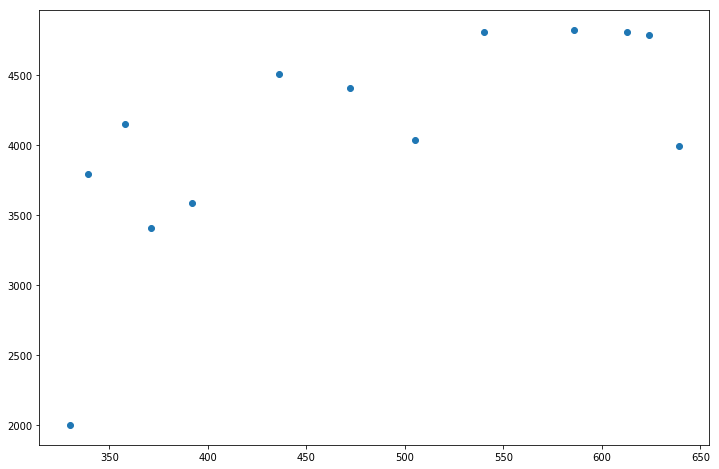

In [14]:
gas = [[(20,3,17),4033], [(17,2,17), 4410], [(12,1,17),4511], [(27,11,16),3586], [(24,10,16),4153], [(5,10,16),3796],
 [(26,9,16),2000], [(31,7,17), 3992], [(9,6,17), 4824], [(24,4,17), 4811], [(5,7,17), 4810], [(6,11,16),3410],
 [(16,7,17), 4783]]
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
cumdays = [days[0]] + [0] * 11
for i in range(1,12):
    cumdays[i] = days[i] + cumdays[i-1]
dates = [ e[0][0] + cumdays[e[0][1]] + sum(days)*(e[0][2] - 16) for e in gas]
prices = [e[1] for e in gas]
fig = plt.figure(figsize=(12,8))
plt.plot(dates, prices, 'o')
plt.show()